In [1]:
device = 'cuda'
c_pretrain_epochs = 20
s_pretrain_epochs = 20
train_epochs = 100
batch_size = 256

In [2]:
import os
import numpy as np
from tqdm import tqdm
import torch
from torch import nn, optim
from matplotlib import pyplot as plt
from datasets.classified_mnist import WatermarkedMNIST
from models.lenet import LeNet5Classifier, LeNet5Sanitizer

In [3]:
classifier = LeNet5Classifier(output_classes=2).to(device)
sanitizer = LeNet5Sanitizer().to(device)

In [4]:
print('Classifier:')
print(classifier)
print('\n\n')
print('Sanitizer:')
print(sanitizer)

Classifier:
LeNet5Classifier(
  (model): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
      (1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (4): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
      (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): ReLU()
      (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): Flatten(start_dim=1, end_dim=-1)
    (2): Sequential(
      (0): Linear(in_features=256, out_features=120, bias=True)
      (1): ReLU()
      (2): Linear(in_features=120, out_features=84, bias=True)
      (3): ReLU()
      (4): Linear(in_features=84, out_features=2, bias=True)
    )
  )
)



Sanitizer:
LeNet5Sanitizer(
  (img_gate_fe): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 

In [5]:
c_opt = optim.Adam(classifier.parameters(), betas=(0.0, 0.999))
s_opt = optim.Adam(sanitizer.parameters(), betas=(0.0, 0.999))

In [6]:
c_loss_fn = nn.CrossEntropyLoss()

class SanitizerLoss(nn.Module):
    def __init__(self):
        super().__init__()
        
    def rec_loss(self, image, target, classifier_logits, sanitizer_logits):
        return nn.functional.l1_loss(sanitizer_logits, image)
    
    def em_loss(self, image, target, classifier_logits, sanitizer_logits):
        return nn.functional.binary_cross_entropy(
            nn.functional.softmax(classifier_logits, dim=-1),
            nn.functional.softmax(torch.zeros_like(classifier_logits), dim=-1)
        )
    
s_loss_fn = SanitizerLoss()

In [7]:
mnist_loc = os.path.join('.', 'downloads', 'MNIST')
os.makedirs(mnist_loc, exist_ok=True)
train_dataset = WatermarkedMNIST(train=True, root=mnist_loc, download=True)
s_train_dataset, c_train_dataset = torch.utils.data.random_split(train_dataset, 2*[len(train_dataset)//2])
test_dataset = WatermarkedMNIST(train=False, root=mnist_loc, download=True)

In [8]:
s_train_dataloader = torch.utils.data.DataLoader(s_train_dataset, batch_size=batch_size, shuffle=True, num_workers=8)
c_train_dataloader = torch.utils.data.DataLoader(c_train_dataset, batch_size=batch_size, shuffle=True, num_workers=8)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, num_workers=8)

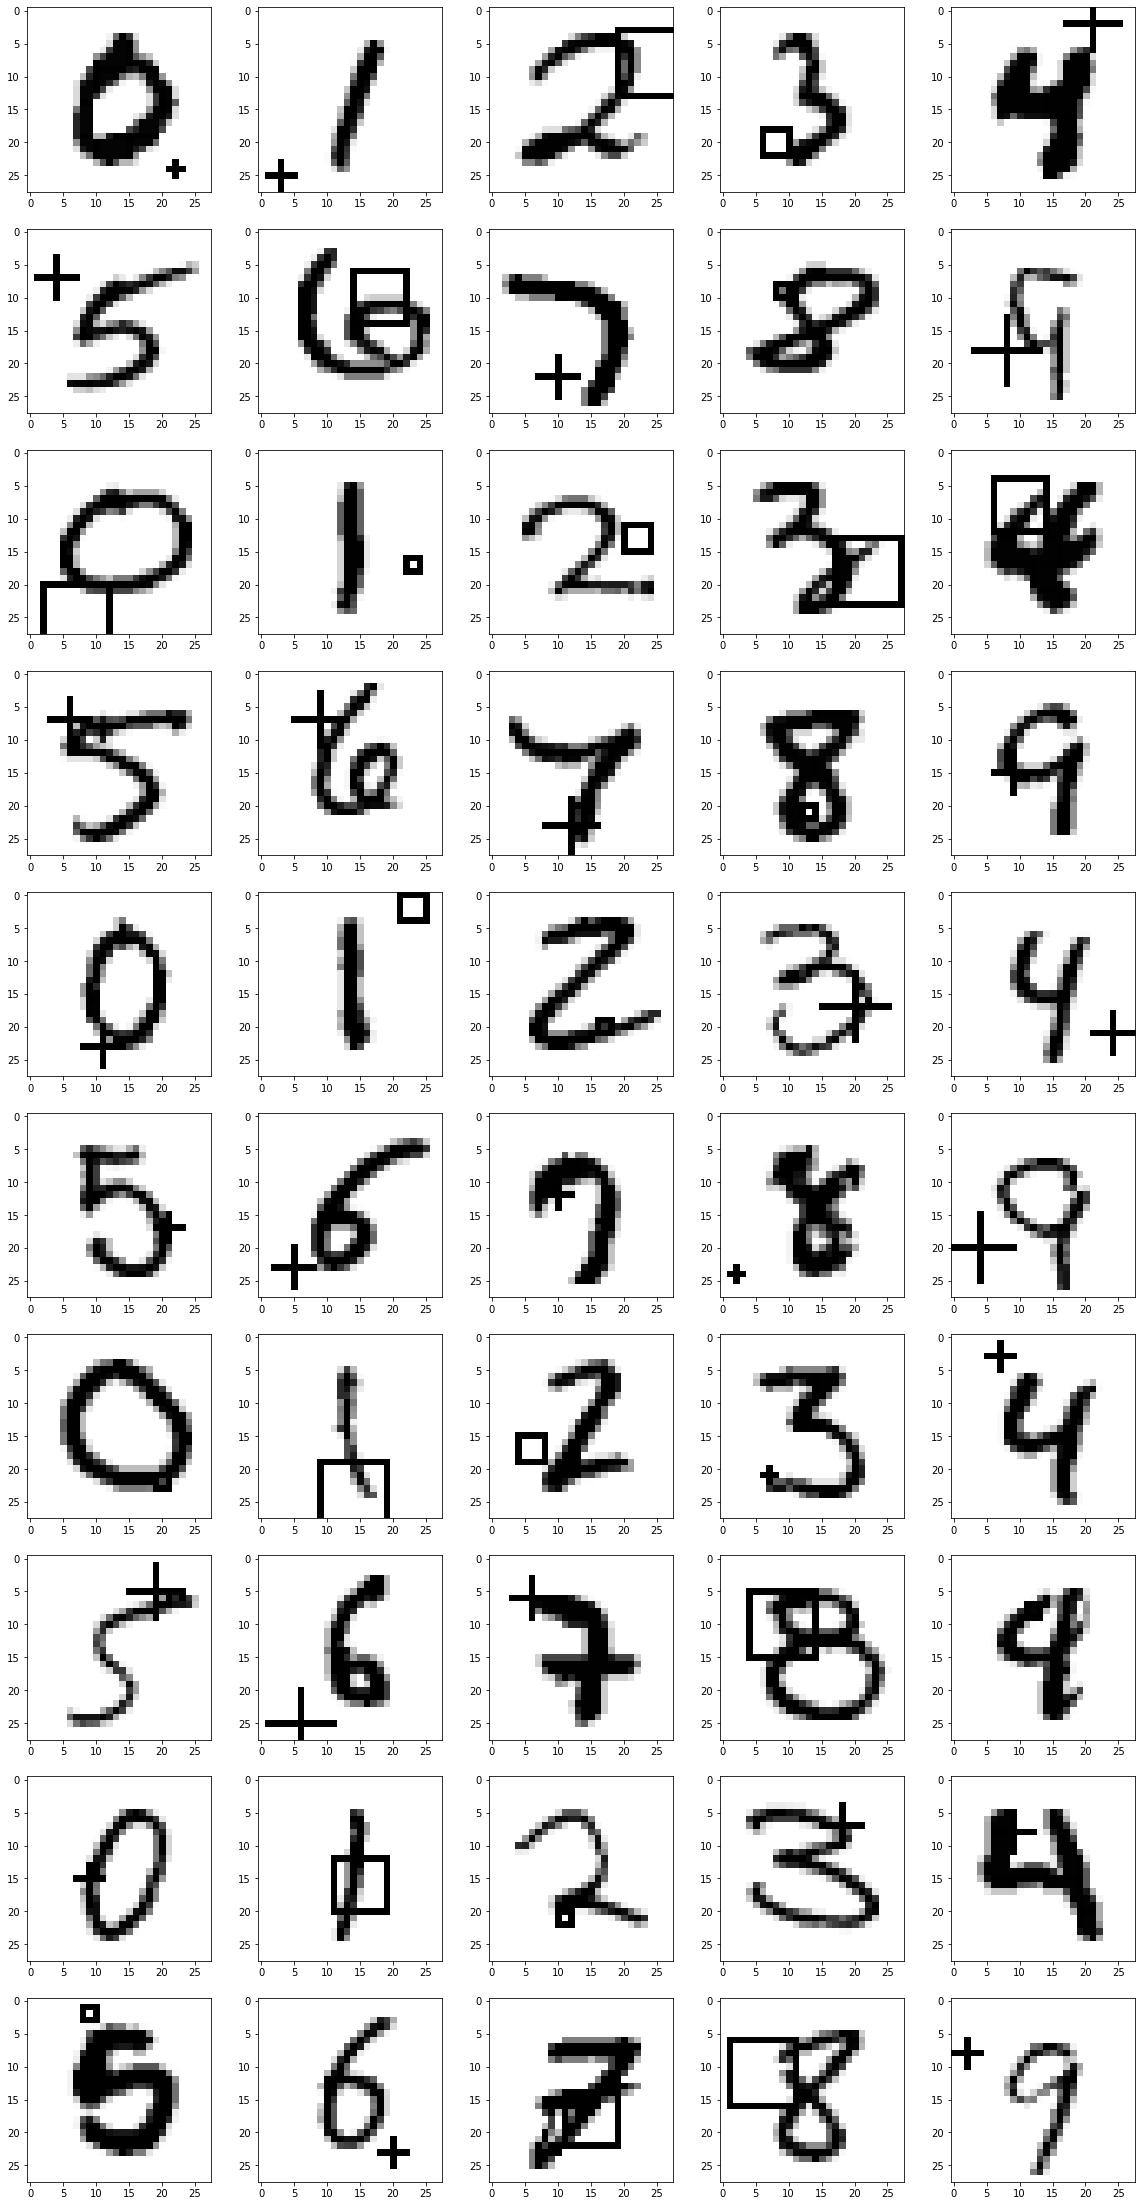

In [9]:
n_samples_to_visualize = 50
sample_images = n_samples_to_visualize*[train_dataset.__getitem__(0)[0]]
sample_indices = n_samples_to_visualize*[0]
targets = (n_samples_to_visualize//10)*[idx for idx in range(10)]
idx = 0
for sidx, target in enumerate(targets):
    image = None
    while image is None:
        image_, target_, _ = test_dataset[idx]
        if target == target_:
            image = image_.squeeze().cpu().numpy()
        else:
            idx += 1
    sample_images[sidx] = image
    sample_indices[sidx] = idx
ax_size_per_image = 4
images_per_row = 5
(fig, axes) = plt.subplots(n_samples_to_visualize//images_per_row, images_per_row, 
                           figsize=(images_per_row*ax_size_per_image, n_samples_to_visualize*ax_size_per_image//images_per_row))
for image, ax in zip(sample_images, axes.flatten()):
    ax.imshow(image, cmap='binary')

In [10]:
def get_sanitized_image(image):
    return nn.functional.hardtanh(sanitizer(image))

def val(x):
    return x.detach().cpu().numpy()

def get_acc(logits, target):
    logits = val(logits)
    target = val(target)
    return np.mean(np.equal(np.argmax(logits, axis=-1), target))

def pretrain_c_step(batches, s_lbd=1.0):
    classifier.train()
    sanitizer.train()
    c_batch, s_batch = batches
    
    # step classifier
    image, _, watermark_target = c_batch
    image, watermark_target = image.to(device), watermark_target.to(device)
    sanitized_image = get_sanitized_image(image).detach()
    c_logits = classifier(sanitized_image)
    c_loss = c_loss_fn(c_logits, watermark_target)
    c_opt.zero_grad()
    c_loss.backward()
    c_opt.step()
    
    # eval sanitizer
    image, _, watermark_target = s_batch
    image, watermark_target = image.to(device), watermark_target.to(device)
    sanitized_image = get_sanitized_image(image).detach()
    c_logits = classifier(sanitized_image)
    s_rec_loss = s_loss_fn.rec_loss(image, watermark_target, c_logits, sanitized_image)
    s_em_loss = s_loss_fn.em_loss(image, watermark_target, c_logits, sanitized_image)
    s_loss = s_em_loss + s_lbd*s_rec_loss
    
    # return results
    return {
        'c_loss': val(c_loss),
        's_em_loss': val(s_em_loss),
        's_rec_loss': val(s_rec_loss),
        'c_acc': get_acc(c_logits, watermark_target)
    }

def pretrain_s_step(batches, s_lbd=0.0):
    classifier.train()
    sanitizer.train()
    c_batch, s_batch = batches
    
    # step sanitizer
    image, _, watermark_target = s_batch
    image, watermark_target = image.to(device), watermark_target.to(device)
    sanitized_image = get_sanitized_image(image)
    c_logits = classifier(sanitized_image)
    s_rec_loss = s_loss_fn.rec_loss(image, watermark_target, c_logits, sanitized_image)
    s_em_loss = s_loss_fn.em_loss(image, watermark_target, c_logits, sanitized_image)
    s_loss = s_em_loss + s_lbd*s_rec_loss
    s_opt.zero_grad()
    s_loss.backward()
    s_opt.step()
    
    # eval classifier
    image, _, watermark_target = c_batch
    image, watermark_target = image.to(device), watermark_target.to(device)
    sanitized_image = get_sanitized_image(image).detach()
    c_logits = classifier(sanitized_image)
    c_loss = c_loss_fn(c_logits, watermark_target)
    
    # return results
    return {
        'c_loss': val(c_loss),
        's_em_loss': val(s_em_loss),
        's_rec_loss': val(s_rec_loss),
        'c_acc': get_acc(c_logits, watermark_target)
    }

def train_step(batches, s_lbd=1.0):
    classifier.train()
    sanitizer.train()
    c_batch, s_batch = batches
    
    # step classifier
    image, _, watermark_target = c_batch
    image, watermark_target = image.to(device), watermark_target.to(device)
    sanitized_image = get_sanitized_image(image).detach()
    c_logits = classifier(sanitized_image)
    c_loss = c_loss_fn(c_logits, watermark_target)
    c_opt.zero_grad()
    c_loss.backward()
    c_opt.step()
    
    # step sanitizer
    image, _, watermark_target = s_batch
    image, watermark_target = image.to(device), watermark_target.to(device)
    sanitized_image = get_sanitized_image(image)
    c_logits = classifier(sanitized_image)
    s_rec_loss = s_loss_fn.rec_loss(image, watermark_target, c_logits, sanitized_image)
    s_em_loss = s_loss_fn.em_loss(image, watermark_target, c_logits, sanitized_image)
    s_loss = s_em_loss + s_lbd*s_rec_loss
    s_opt.zero_grad()
    s_loss.backward()
    s_opt.step()
    
    # return results
    return {
        'c_loss': val(c_loss),
        's_em_loss': val(s_em_loss),
        's_rec_loss': val(s_rec_loss),
        'c_acc': get_acc(c_logits, watermark_target)
    }

@torch.no_grad()
def eval_step(batches, s_lbd=1.0):
    classifier.eval()
    sanitizer.eval()
    if type(batches) == tuple:
        c_batch, s_batch = batches
    else:
        c_batch = s_batch = batches
    
    # eval classifier
    image, _, watermark_target = c_batch
    image, watermark_target = image.to(device), watermark_target.to(device)
    sanitized_image = get_sanitized_image(image).detach()
    c_logits = classifier(sanitized_image)
    c_loss = c_loss_fn(c_logits, watermark_target)
    
    # eval sanitizer
    image, _, watermark_target = s_batch
    image, watermark_target = image.to(device), watermark_target.to(device)
    sanitized_image = get_sanitized_image(image).detach()
    c_logits = classifier(sanitized_image)
    s_em_loss = s_loss_fn.em_loss(image, watermark_target, c_logits, sanitized_image)
    s_rec_loss = s_loss_fn.rec_loss(image, watermark_target, c_logits, sanitized_image)
    
    # return results
    return {
        'c_loss': val(c_loss),
        's_em_loss': val(s_em_loss),
        's_rec_loss': val(s_rec_loss),
        'c_acc': get_acc(c_logits, watermark_target)
    }

def run_epoch(dataloader, step_fn, pref='', s_lbd=1.0):
    results = {}
    if hasattr(dataloader, '__getitem__'):
        dataloader = zip(*dataloader)
    for batch in dataloader:
        rv = step_fn(batch, s_lbd=s_lbd)
        for key in rv.keys():
            if not pref+key in results.keys():
                results[pref+key] = []
            results[pref+key].append(rv[key])
    for key, item in results.items():
        results[key] = np.mean(item)
    return results

In [11]:
results = {}
progress_bar = tqdm(total=2*(1+c_pretrain_epochs+s_pretrain_epochs+train_epochs))
def update_results(rv):
    for key in rv.keys():
        if not key in results.keys():
            results[key] = []
        results[key].append(rv[key])
    progress_bar.update(1)

update_results(run_epoch([c_train_dataloader, s_train_dataloader], eval_step, 'tr_'))
update_results(run_epoch(test_dataloader, eval_step, 'te_'))
for epoch in range(s_pretrain_epochs):
    update_results(run_epoch([c_train_dataloader, s_train_dataloader], pretrain_s_step, 'tr_', s_lbd=0.0))
    update_results(run_epoch(test_dataloader, eval_step, 'te_', s_lbd=0.0))
for epoch in range(c_pretrain_epochs):
    update_results(run_epoch([c_train_dataloader, s_train_dataloader], pretrain_c_step, 'tr_'))
    update_results(run_epoch(test_dataloader, eval_step, 'te_'))
for epoch in range(train_epochs):
    update_results(run_epoch([c_train_dataloader, s_train_dataloader], train_step, 'tr_', s_lbd=0.1))
    update_results(run_epoch(test_dataloader, eval_step, 'te_'))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 282/282 [08:55<00:00,  1.74s/it]

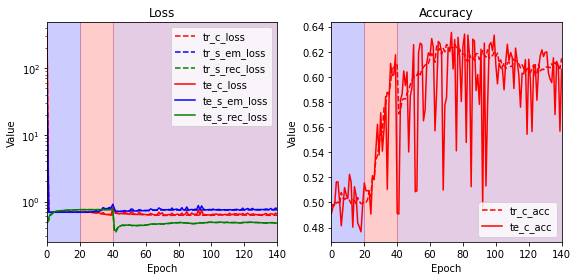

In [12]:
(fig, axes) = plt.subplots(1, 2, sharex=True, figsize=(8, 4))
epochs = np.arange(1+c_pretrain_epochs+s_pretrain_epochs+train_epochs)
for key, item in results.items():
    ax = axes[0] if 'loss' in key else axes[1]
    ax.plot(epochs, item,
            color='red' if key.split('_')[1]=='c' else 'blue' if key.split('_')[2]=='em' else 'green',
            linestyle='--' if key.split('_')[0]=='tr' else '-',
            label=key)
for ax in axes.flatten():
    ax.legend()
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Value')
    ax.set_xlim(0, s_pretrain_epochs+c_pretrain_epochs+train_epochs)
    ax.axvspan(0, s_pretrain_epochs, alpha=0.2, color='blue')
    ax.axvspan(s_pretrain_epochs, s_pretrain_epochs+c_pretrain_epochs, alpha=0.2, color='red')
    ax.axvspan(s_pretrain_epochs+c_pretrain_epochs, s_pretrain_epochs+c_pretrain_epochs+train_epochs, alpha=0.2, color='purple')
axes[0].set_yscale('log')
axes[0].set_title('Loss')
axes[1].set_title('Accuracy')
plt.tight_layout()

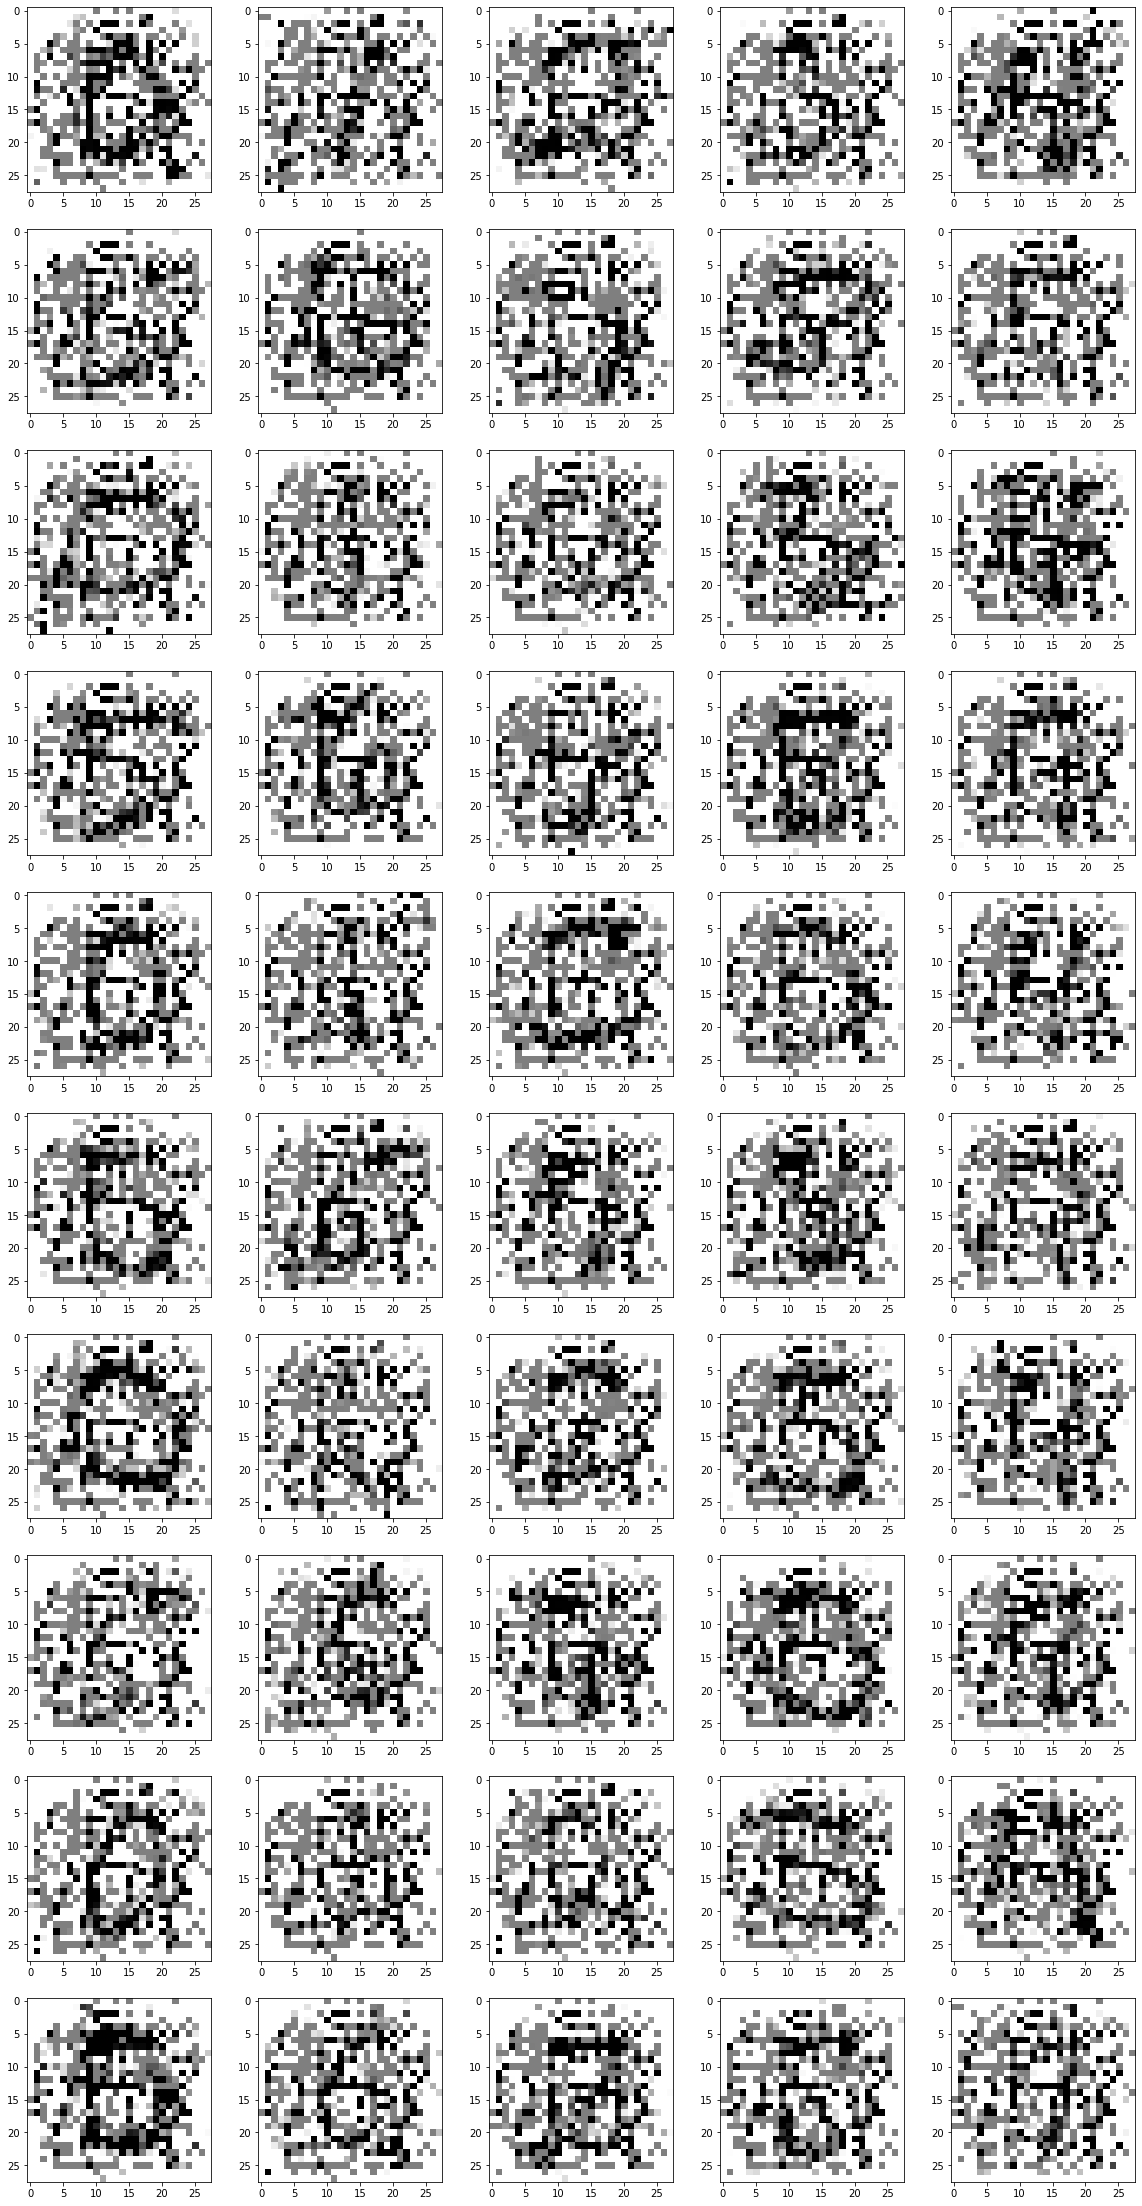

In [13]:
classifier.eval()
sanitizer.eval()
n_samples_to_visualize = 50
sample_images = n_samples_to_visualize*[train_dataset.__getitem__(0)[0]]
sample_indices = n_samples_to_visualize*[0]
targets = (n_samples_to_visualize//10)*[idx for idx in range(10)]
idx = 0
for sidx, target in enumerate(targets):
    image = None
    while image is None:
        image_, target_, _ = test_dataset[idx]
        if target == target_:
            image = val(get_sanitized_image(image_.to(device).unsqueeze(0)).squeeze())
        else:
            idx += 1
    sample_images[sidx] = image
    sample_indices[sidx] = idx
ax_size_per_image = 4
images_per_row = 5
(fig, axes) = plt.subplots(n_samples_to_visualize//images_per_row, images_per_row, 
                           figsize=(images_per_row*ax_size_per_image, n_samples_to_visualize*ax_size_per_image//images_per_row))
for image, ax in zip(sample_images, axes.flatten()):
    ax.imshow(image, cmap='binary')